In [1]:
import pickle
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

from matplotlib import rcParams
rcParams['font.size'] = 14
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

print(tf.__version__)

2.0.0


### Definitions

In [2]:
# autoencoder_model = './models/SGD_0.01_encoder_100-1-model.h5'
# autoencoder_model = './models/all_SGD_0.01_encoder_400-100-40-5-model.h5'
# dataset_filter = 'all'
dataset_filter = 'normal'

optimizer_name = 'SGD'
lr = 0.01

base_autoencoder_model = r'./models/{}_{}_{}_encoder_{}-model.h5'

In [3]:
# PCA definitions
number_components = [x for x in range(1, 9)]

In [4]:
num_tests = 50 # number of tests to be performed and obtain average accuracy
samples_normal = 100
samples_abnormal = 15

In [5]:
# DBSCAN definitions
epsilon_configurations = [.1, .5, 1., 2., 3., 4., 5., 10.]
min_samples_configurations = [3, 5, 8, 10, 12, 15, 20, 50, 80, 100]

In [6]:
# OC-SVM definitions
gammas = [0.001, 0.1, 0.2, 0.5, 0.7, 1.0]
kernels = ['rbf', 'linear', 'sigmoid'] # , 'poly'
nus = [0.01, 0.1, .3, .5, .7, 1.]

In [7]:
folder = '/nobackup/carda/datasets/ml-simulation-optical/2019-ecoc-demo'

### Importing dataset

In [8]:
with open(folder + '/compiled-dataset.h5', 'rb') as file:
    final_dataframe, scaled_dataframe, class_columns, class_names = pickle.load(file)
input_dim = final_dataframe.shape[1] - 3 # the last three columns are classes

### Helper functions

In [9]:

# sort the OCSVM results dictionary by the performance
def get_sorted_pairs_ocsvm(performance):
    values = sorted([[performance[kernel][nu][gamma]['false_positive_rate'], performance[kernel][nu][gamma]['false_negative_rate']] for kernel in performance for nu in performance[kernel] for gamma in performance[kernel][nu]], key=lambda x: x[0])
    return values

# sort the DBSCAN results dictionary by the performance
def get_sorted_pairs_dbscan(performance):
    values = sorted([[performance[layer][epsilon]['false_positive_rate'], performance[layer][epsilon]['false_negative_rate']] for layer in performance for epsilon in performance[layer]], key=lambda x: x[0])
    return values

# get best OCSVM f1 score
def get_best_ocsvm(performance):
    best_f1 = .0
    best = None
    for kernel in performance.keys():
        for nu in performance[kernel].keys():
            for gamma in performance[kernel][nu].keys():
                if performance[kernel][nu][gamma]['f1_score'] > best_f1:
                    best_f1 = performance[kernel][nu][gamma]['f1_score']
                    best = performance[kernel][nu][gamma]
    return best

# get best DBSCAN f1 score
def get_best_dbscan(performance):
    best_f1 = .0
    best = None
    for layer in performance.keys():
        for epsilon in performance[layer].keys():
            if performance[layer][epsilon]['f1_score'] > best_f1:
                best_f1 = performance[layer][epsilon]['f1_score']
                best = performance[layer][epsilon]
    return best

def get_curve(sorted_pairs):
    curve_fpr = []
    curve_fnr = []

    last_x = sorted_pairs[0][0]
    last_y = sorted_pairs[0][1]

    curve_fpr.append(sorted_pairs[0][0])
    curve_fnr.append(sorted_pairs[0][1])
    
    for x, y in sorted_pairs:
        if x > curve_fpr[-1] and y < curve_fnr[-1]:
            curve_fpr.append(x)
            curve_fnr.append(y)
    return curve_fpr, curve_fnr

### Loading autoencoder and preparing the encoder

In [10]:
# model = tf.keras.models.load_model(autoencoder_model)
# model.summary()
# output_layer = len(model.layers) // 2
# encoder = tf.keras.Model(inputs=model.input, outputs=model.layers[output_layer-1].output)
# print()
# encoder.summary()

### Running the encoder with DBSCAN

In [11]:
performance_dbscan_encoder = {}
highest_f1 = 0.

encoder_layers = [
    (40,),
    (100, 40),
    (400, 100, 40),
]

for n_components in number_components:
    performance_dbscan_encoder[n_components] = {}
    for layer in encoder_layers:
        performance_dbscan_encoder[n_components][layer] = {}
        for idm, min_samples in enumerate(min_samples_configurations):
            performance_dbscan_encoder[n_components][layer][min_samples] = {}
            for ide, epsilon in enumerate(epsilon_configurations):
                performance_dbscan_encoder[n_components][layer][min_samples][epsilon] = {}

print('ncomp\t    layer \tMinPts\tepsilon\t\tfpr\tfnr\tf1')
for n_components in number_components:
    for layer in encoder_layers:
        layers = layer + (n_components,)
    #     print('-'.join([str(x) for x in layer]))
        model = tf.keras.models.load_model(base_autoencoder_model.format(dataset_filter, optimizer_name, lr, '-'.join(str(x) for x in layers)))
        
        output_layer = len(model.layers) // 2
        encoder = tf.keras.Model(inputs=model.input, outputs=model.layers[output_layer-1].output)
        encoder.summary()
        encoded_data = encoder.predict(scaled_dataframe.drop(class_columns, axis=1).values)
        print(np.mean(encoded_data), np.std(encoded_data))
    #         print(encoded_data.shape, [f'ed_{i}' for i in range(1, n_components+1)])

    #     scaler = StandardScaler().fit(encoded_data)
    #     encoded_data = scaler.transform(encoded_data)
    #     print(np.mean(encoded_data), np.std(encoded_data))

        encoded_df = pd.DataFrame(data=encoded_data, columns=[f'ed_{i}' for i in range(1, n_components+1)])

        class_df = pd.DataFrame(data=scaled_dataframe[class_columns], columns=class_columns)

        working_df = pd.concat([encoded_df, class_df], axis=1)
    #         working_df.describe()
    #         break

        for idm, min_samples in enumerate(min_samples_configurations):

            for ide, epsilon in enumerate(epsilon_configurations):

                clf = DBSCAN(eps=epsilon, min_samples=min_samples, metric='euclidean')

                true_positives = []
                false_negatives = []
                true_negatives = []
                false_positives = []
                precisions = []
                recalls = []
                f1_scores = []

                for test in range(num_tests):
                    p1 = working_df[(working_df['path_1'] == 1) & (working_df['attack'] == 0)].sample(samples_normal)
                    p2 = working_df[(working_df['path_2'] == 1) & (working_df['attack'] == 0)].sample(samples_normal)
                    x_data = np.concatenate((p1.values[:, :-3], p2.values[:, :-3]), axis=0)
                    y_data = np.concatenate((p1.values[:, -1], p2.values[:, -1]), axis=0)

                    # start copy
                    for i in range(num_tests):
                        x_data_test = np.copy(x_data)
                        y_data_test = np.copy(y_data)
                        for clazz in range(1, len(class_names)):
                            x = working_df[(working_df['path_1'] == 1) & (working_df['attack'] == clazz)].sample(samples_abnormal)
                            x_data_test = np.concatenate((x_data_test, x.values[:, :-3]), axis=0)
                            y_data_test = np.concatenate((y_data_test, x.values[:, -1]), axis=0)

                            x = working_df[(working_df['path_2'] == 1) & (working_df['attack'] == clazz)].sample(samples_abnormal)
                            x_data_test = np.concatenate((x_data_test, x.values[:, :-3]), axis=0)
                            y_data_test = np.concatenate((y_data_test, x.values[:, -1]), axis=0)

                        y_pred = clf.fit_predict(x_data_test)

                        tpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])
                        fnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] >= 0 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])

                        tnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] >= 0 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])
                        fpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])

                        if tpr == 0: # avoids division by zero
                            precision = 0.
                            recall = 0.
                            f1 = 0.
                        else:
                            precision = tpr / (tpr + fpr)
                            recall = tpr / (tpr + fnr)
                            f1 = 2 * precision * recall / (precision + recall)

                        true_positives.append(tpr)
                        false_negatives.append(fnr)
                        true_negatives.append(tnr)
                        false_positives.append(fpr)
                        precisions.append(precision)
                        recalls.append(recall)
                        f1_scores.append(f1)

                performance_dbscan_encoder[n_components][layer][min_samples][epsilon]['n_components'] = n_components
                performance_dbscan_encoder[n_components][layer][min_samples][epsilon]['layer'] = layer
                performance_dbscan_encoder[n_components][layer][min_samples][epsilon]['min_samples'] = min_samples
                performance_dbscan_encoder[n_components][layer][min_samples][epsilon]['epsilon'] = epsilon

                performance_dbscan_encoder[n_components][layer][min_samples][epsilon]['true_positive_rate'] = np.mean(true_positives)
                performance_dbscan_encoder[n_components][layer][min_samples][epsilon]['false_negative_rate'] = np.mean(false_negatives)
                performance_dbscan_encoder[n_components][layer][min_samples][epsilon]['true_negative_rate'] = np.mean(true_negatives)
                performance_dbscan_encoder[n_components][layer][min_samples][epsilon]['false_positive_rate'] = np.mean(false_positives)
                performance_dbscan_encoder[n_components][layer][min_samples][epsilon]['precision'] = np.mean(precisions)
                performance_dbscan_encoder[n_components][layer][min_samples][epsilon]['recall'] = np.mean(recalls)
                performance_dbscan_encoder[n_components][layer][min_samples][epsilon]['f1_score'] = np.mean(f1_scores)
                msg = ''
                if performance_dbscan_encoder[n_components][layer][min_samples][epsilon]['f1_score'] > highest_f1:
                    msg = '\t * highest'
                    highest_f1 = performance_dbscan_encoder[n_components][layer][min_samples][epsilon]['f1_score']
                print(f'{n_components:>4}\t{"-".join(str(x) for x in layer[:-1]):>10}\t{min_samples:>6}\t', f'{epsilon:>6}', '\t{:.3f}\t{:.3f}\t{:.3f}\t'.format(performance_dbscan_encoder[n_components][layer][min_samples][epsilon]['false_positive_rate'],
                            performance_dbscan_encoder[n_components][layer][min_samples][epsilon]['false_negative_rate'],
                            performance_dbscan_encoder[n_components][layer][min_samples][epsilon]['f1_score']), msg)

print('done')

ncomp	    layer 	MinPts	epsilon		fpr	fnr	f1
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_and_0_input (InputLaye [(None, 31)]              0         
_________________________________________________________________
input_and_0 (Dense)          (None, 40)                1280      
_________________________________________________________________
decoder_1 (Dense)            (None, 1)                 41        
Total params: 1,321
Trainable params: 1,321
Non-trainable params: 0
_________________________________________________________________
0.042414747 2.3805776
   1	          	     3	    0.1 	0.005	0.941	0.110	 	 * highest
   1	          	     3	    0.5 	0.000	0.997	0.007	 
   1	          	     3	    1.0 	0.000	0.998	0.003	 
   1	          	     3	    2.0 	0.000	0.999	0.001	 
   1	          	     3	    3.0 	0.000	1.000	0.000	 
   1	          	     3	    4.0 	0.000	1.000	0.000	 


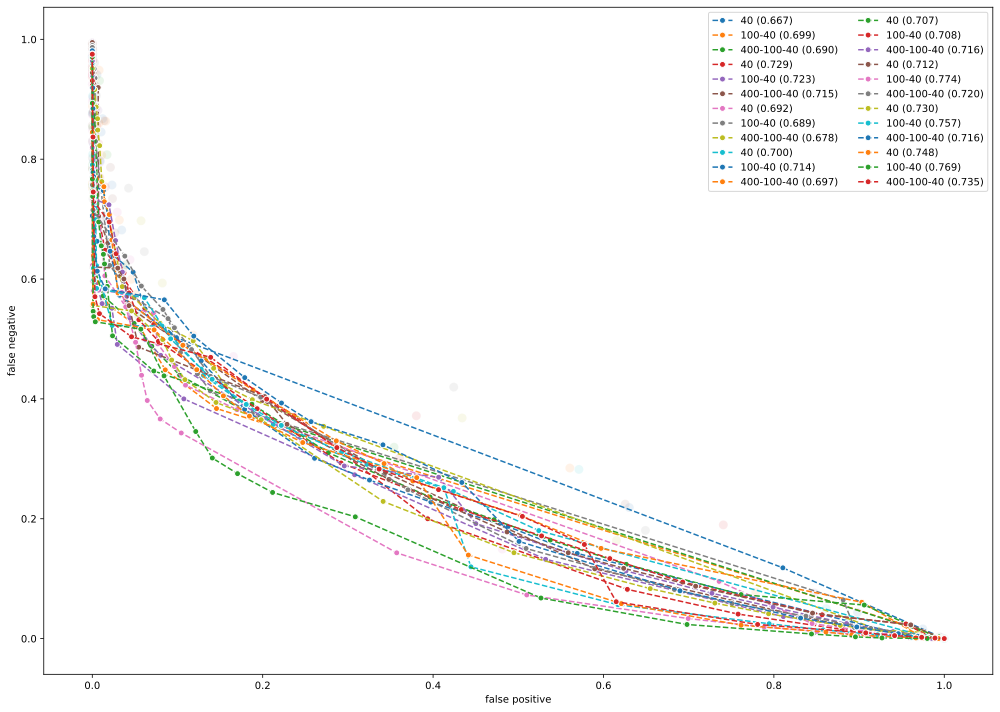

In [12]:
plt.figure(figsize=(14, 10))

for n_components in number_components:
    for layer in encoder_layers:

        sorted_pairs = get_sorted_pairs_dbscan(performance_dbscan_encoder[n_components][layer])
        curve_fpr, curve_fnr = get_curve(sorted_pairs)

        best_f1 = get_best_dbscan(performance_dbscan_encoder[n_components][layer])

        ax = plt.scatter([x for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr], 
                    [y for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr], 
                    marker='o', s=80, alpha=0.1, edgecolors='white', zorder=1)

        layer_str = '-'.join(str(x) for x in layer)
        plt.plot(curve_fpr, curve_fnr, ls='--', marker='o', alpha=1., markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label=f"{layer_str} ({best_f1['f1_score']:.3f})")
    
#     sorted_pairs = get_sorted_pairs_dbscan(performance_dbscan[n_components])
#     curve_fpr, curve_fnr = get_curve(sorted_pairs)
    
#     best_f1 = get_best_dbscan(performance_dbscan[n_components])
    
#     ax = plt.scatter([x for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr], 
#                 [y for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr], 
#                 marker='s', s=80, alpha=0.1, edgecolors='white', zorder=1)
    
#     plt.plot(curve_fpr, curve_fnr, ls=':', marker='s', alpha=1., markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label=f"{n_components} ({best_f1['f1_score']:.3f})")

# plt.title('DBSCAN - PCA (square) vs. Enc. (circle)')
plt.xlabel('false positive')
plt.ylabel('false negative')
plt.legend(ncol=2)
plt.tight_layout()
plt.savefig('./figures/{}_{}_{}_pca_enc_dbscan.pdf'.format(dataset_filter, optimizer_name, lr))
plt.show()

### Running the encoder with OCSVM

In [13]:
performance_ocsvm_encoder = {}
highest_f1 = .0

for n_components in number_components:
    performance_ocsvm_encoder[n_components] = {}
    for layer in encoder_layers:
        performance_ocsvm_encoder[n_components][layer] = {}
        for kernel in kernels:
            performance_ocsvm_encoder[n_components][layer][kernel] = {}
            for nu in nus:
                performance_ocsvm_encoder[n_components][layer][kernel][nu] = {}
                for gamma in gammas:
                    performance_ocsvm_encoder[n_components][layer][kernel][nu][gamma] = {}

print('npca\t    layers\t    kernel\t    nu\t gamma\t\tfpr\tfnr\tf1')
for n_components in number_components:
    for layer in encoder_layers:
        layers = layer + (n_components,)

        model = tf.keras.models.load_model(base_autoencoder_model.format(dataset_filter, optimizer_name, lr, '-'.join(str(x) for x in layers)))
        output_layer = len(model.layers) // 2
        encoder = tf.keras.Model(inputs=model.input, outputs=model.layers[output_layer-1].output)
        encoder.summary()
        encoded_data = encoder.predict(scaled_dataframe.drop(class_columns, axis=1).values)
        print(np.mean(encoded_data), np.std(encoded_data))
    #         print(encoded_data.shape, [f'ed_{i}' for i in range(1, n_components+1)])

#         scaler = StandardScaler().fit(encoded_data)
#         encoded_data = scaler.transform(encoded_data)
#         print(np.mean(encoded_data), np.std(encoded_data))

        encoded_df = pd.DataFrame(data=encoded_data, columns=[f'ed_{i}' for i in range(1, n_components+1)])

        class_df = pd.DataFrame(data=scaled_dataframe[class_columns], columns=class_columns)

        working_df = pd.concat([encoded_df, class_df], axis=1)

        for kernel in kernels:
            for nu in nus:
                for gamma in gammas:

    #                 print('components', performance_ocsvm_encoder.keys())
    #                 print('\tlayer', performance_ocsvm_encoder[n_components].keys())
    #                 print('\tkernel', performance_ocsvm_encoder[n_components][layer].keys())
    #                 print('\tnu', performance_ocsvm_encoder[n_components][layer][kernel].keys())
    #                 print('\tgamma', performance_ocsvm_encoder[n_components][layer][kernel][nu].keys())

                    clf = svm.OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
                    true_positives = []
                    false_negatives = []
                    true_negatives = []
                    false_positives = []
                    precisions = []
                    recalls = []
                    f1_scores = []
                    for i in range(num_tests):
                        p1 = working_df[(working_df['path_1'] == 1) & (working_df['attack'] == 0)].sample(samples_normal)
                        p2 = working_df[(working_df['path_2'] == 1) & (working_df['attack'] == 0)].sample(samples_normal)
                        x_data = np.concatenate((p1.values[:, :-3], p2.values[:, :-3]), axis=0)
                        y_data = np.concatenate((p1.values[:, -1], p2.values[:, -1]), axis=0)

                        clf.fit(x_data)

                        for test in range(num_tests):
                            x_data_test = np.copy(x_data)
                            y_data_test = np.copy(y_data)
                            for clazz in range(1, len(class_names)):
                                x = working_df[(working_df['path_1'] == 1) & (working_df['attack'] == clazz)].sample(samples_abnormal)
                                x_data_test = np.concatenate((x_data_test, x.values[:, :-3]), axis=0)
                                y_data_test = np.concatenate((y_data_test, x.values[:, -1]), axis=0)

                                x = working_df[(working_df['path_2'] == 1) & (working_df['attack'] == clazz)].sample(samples_abnormal)
                                x_data_test = np.concatenate((x_data_test, x.values[:, :-3]), axis=0)
                                y_data_test = np.concatenate((y_data_test, x.values[:, -1]), axis=0)

                            y_pred = clf.predict(x_data_test)

                            tpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])
                            fnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == 1 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])

                            tnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == 1 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])
                            fpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])

                            if tpr == 0: # avoids division by zero
                                precision = 0.
                                recall = 0.
                                f1 = 0.
                            else:
                                precision = tpr / (tpr + fpr)
                                recall = tpr / (tpr + fnr)
                                f1 = 2 * precision * recall / (precision + recall)

                            true_positives.append(tpr)
                            false_negatives.append(fnr)
                            true_negatives.append(tnr)
                            false_positives.append(fpr)
                            precisions.append(precision)
                            recalls.append(recall)
                            f1_scores.append(f1)

                    performance_ocsvm_encoder[n_components][layer][kernel][nu][gamma]['n_components'] = n_components
                    performance_ocsvm_encoder[n_components][layer][kernel][nu][gamma]['layer'] = layer
                    performance_ocsvm_encoder[n_components][layer][kernel][nu][gamma]['kernel'] = kernel
                    performance_ocsvm_encoder[n_components][layer][kernel][nu][gamma]['nu'] = nu
                    performance_ocsvm_encoder[n_components][layer][kernel][nu][gamma]['gamma'] = gamma

                    performance_ocsvm_encoder[n_components][layer][kernel][nu][gamma]['true_positive_rate'] = np.mean(true_positives)
                    performance_ocsvm_encoder[n_components][layer][kernel][nu][gamma]['false_negative_rate'] = np.mean(false_negatives)
                    performance_ocsvm_encoder[n_components][layer][kernel][nu][gamma]['true_negative_rate'] = np.mean(true_negatives)
                    performance_ocsvm_encoder[n_components][layer][kernel][nu][gamma]['false_positive_rate'] = np.mean(false_positives)
                    performance_ocsvm_encoder[n_components][layer][kernel][nu][gamma]['precision'] = np.mean(precisions)
                    performance_ocsvm_encoder[n_components][layer][kernel][nu][gamma]['recall'] = np.mean(recalls)
                    performance_ocsvm_encoder[n_components][layer][kernel][nu][gamma]['f1_score'] = np.mean(f1_scores)
                    msg = ''
                    if performance_ocsvm_encoder[n_components][layer][kernel][nu][gamma]['f1_score'] > highest_f1:
                        msg = '\t * highest'
                        highest_f1 = performance_ocsvm_encoder[n_components][layer][kernel][nu][gamma]['f1_score']
                    print(f'{n_components:>4}\t{"-".join(str(x) for x in layer):>10}\t{kernel:>10}\t', f'{nu:>6}\t', f'{gamma:>6}', '\t{:.3f}\t{:.3f}\t{:.3f}\t'.format(performance_ocsvm_encoder[n_components][layer][kernel][nu][gamma]['false_positive_rate'],
                            performance_ocsvm_encoder[n_components][layer][kernel][nu][gamma]['false_negative_rate'],
                            performance_ocsvm_encoder[n_components][layer][kernel][nu][gamma]['f1_score']), msg)
print('done')

npca	    layers	    kernel	    nu	 gamma		fpr	fnr	f1
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_and_0_input (InputLaye [(None, 31)]              0         
_________________________________________________________________
input_and_0 (Dense)          (None, 40)                1280      
_________________________________________________________________
decoder_1 (Dense)            (None, 1)                 41        
Total params: 1,321
Trainable params: 1,321
Non-trainable params: 0
_________________________________________________________________
0.042414747 2.3805776
   1	        40	       rbf	   0.01	  0.001 	0.013	0.963	0.070	 	 * highest
   1	        40	       rbf	   0.01	    0.1 	0.009	0.601	0.565	 	 * highest
   1	        40	       rbf	   0.01	    0.2 	0.011	0.608	0.558	 
   1	        40	       rbf	   0.01	    0.5 	0.010	0.607	0.559	 
   1	        40	       rbf	   0.0

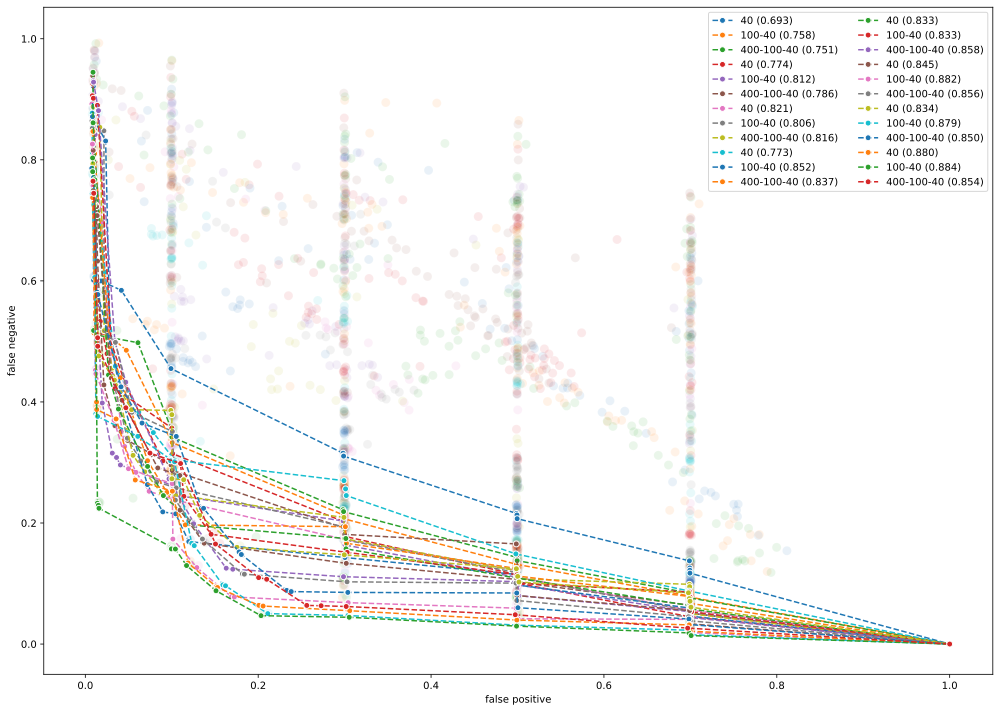

In [14]:
plt.figure(figsize=(14, 10))

for n_components in number_components:
    for layer in encoder_layers:

        sorted_pairs = get_sorted_pairs_ocsvm(performance_ocsvm_encoder[n_components][layer])
        curve_fpr, curve_fnr = get_curve(sorted_pairs)

        best_f1 = get_best_ocsvm(performance_ocsvm_encoder[n_components][layer])

        ax = plt.scatter([x for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr], 
                    [y for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr], 
                    marker='o', s=80, alpha=0.1, edgecolors='white', zorder=1)

        layer_str = '-'.join(str(x) for x in layer)
        plt.plot(curve_fpr, curve_fnr, ls='--', marker='o', alpha=1., markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label=f"{layer_str} ({best_f1['f1_score']:.3f})")
    
#     sorted_pairs = get_sorted_pairs_ocsvm(performance_ocsvm[n_components])
#     curve_fpr, curve_fnr = get_curve(sorted_pairs)
    
#     best_f1 = get_best_ocsvm(performance_ocsvm[n_components])
    
#     ax = plt.scatter([x for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr], 
#                 [y for x, y in sorted_pairs if x not in curve_fpr and y not in curve_fnr], 
#                 marker='s', s=80, alpha=0.1, edgecolors='white', zorder=1)
    
#     plt.plot(curve_fpr, curve_fnr, ls=':', marker='s', alpha=1., markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label=f"{n_components} ({best_f1['f1_score']:.3f})")
# plt.title('OCSVM - PCA (square) vs. Enc (circle)')
plt.xlabel('false positive')
plt.ylabel('false negative')
plt.legend(ncol=2)
plt.tight_layout()
plt.savefig('./figures/{}_{}_{}_pca_enc_ocsvm.pdf'.format(dataset_filter, optimizer_name, lr))
plt.show()

In [15]:
with open('./models/{}_{}_{}_accuracy_results.h5'.format(dataset_filter, optimizer_name, lr), 'wb') as file:
    pickle.dump({'performance_dbscan_encoder': performance_dbscan_encoder,
                'performance_ocsvm_encoder': performance_ocsvm_encoder}, file)